In [109]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
train = pd.read_csv('LSTM_train.csv')
test = pd.read_csv('LSTM-test-USA.csv')

In [111]:
train.head()
test.head()

,date,country,province,confirmed
0,1/22/2020,91,14,0
1,1/22/2020,91,15,0
2,1/22/2020,91,16,0
3,1/22/2020,91,17,0
4,1/22/2020,91,18,0


In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23426 entries, 0 to 23425
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       23426 non-null  object
 1   country    23426 non-null  int64 
 2   province   23426 non-null  int64 
 3   confirmed  23426 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 732.2+ KB


In [113]:
train["year"] = pd.to_datetime(train["date"]).dt.year
#train["date"] = pd.to_datetime(train["date"]).dt.date
train["month"] = pd.to_datetime(train["date"]).dt.month
#train["month_year"] = pd.to_datetime(train["date"]).dt.to_period('M')
#train["date_month"] = pd.to_datetime(train["date"]).dt.to_period('D')
train["date-country-prov"]= train['date'].astype(str)+"-"+train['country'].astype(str)+"-"+train['province'].astype(str)
train.head()

,date,country,province,confirmed,year,month,date-country-prov
0,1/22/2020,1,1,2,2020,1,1/22/2020-1-1
1,1/22/2020,2,1,2,2020,1,1/22/2020-2-1
2,1/22/2020,3,1,0,2020,1,1/22/2020-3-1
3,1/22/2020,4,1,0,2020,1,1/22/2020-4-1
4,1/22/2020,5,1,0,2020,1,1/22/2020-5-1


In [114]:
test["year"] = pd.to_datetime(test["date"]).dt.year
#test["date"] = pd.to_datetime(test["date"]).dt.date
test["month"] = pd.to_datetime(test["date"]).dt.month
#test["month_year"] = pd.to_datetime(test["date"]).dt.to_period('M')
#test["date_month"] = pd.to_datetime(test["date"]).dt.to_period('D')
test["date-country-prov"]= test['date'].astype(str)+"-"+test['country'].astype(str)+"-"+test['province'].astype(str)
test.head()

,date,country,province,confirmed,year,month,date-country-prov
0,1/22/2020,91,14,0,2020,1,1/22/2020-91-14
1,1/22/2020,91,15,0,2020,1,1/22/2020-91-15
2,1/22/2020,91,16,0,2020,1,1/22/2020-91-16
3,1/22/2020,91,17,0,2020,1,1/22/2020-91-17
4,1/22/2020,91,18,0,2020,1,1/22/2020-91-18


In [115]:
train = train.set_index("date")
train.head()

,country,province,confirmed,year,month,date-country-prov
date,,,,,,
1/22/2020,1,1,2,2020,1,1/22/2020-1-1
1/22/2020,2,1,2,2020,1,1/22/2020-2-1
1/22/2020,3,1,0,2020,1,1/22/2020-3-1
1/22/2020,4,1,0,2020,1,1/22/2020-4-1
1/22/2020,5,1,0,2020,1,1/22/2020-5-1


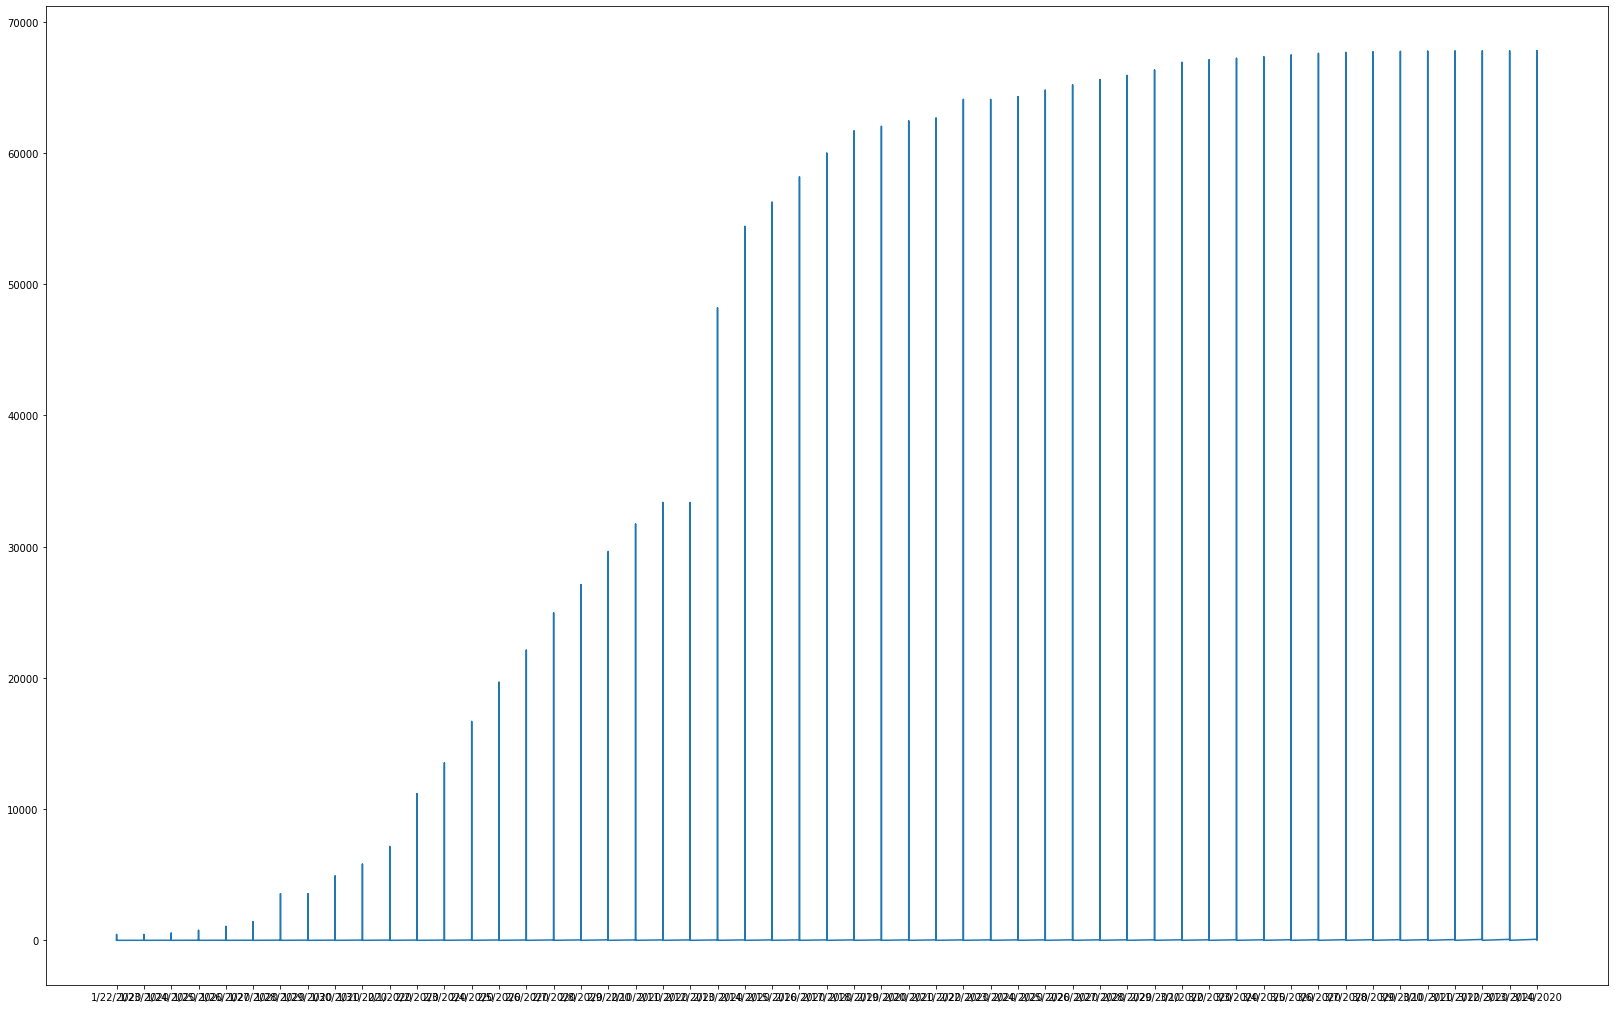

In [116]:
plt.figure(figsize=(28,18))
plt.plot(train.index, train['confirmed'], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Number of Covid-19 cases')
plt.show()

In [117]:
train.index.freq = 'MS'

In [118]:
#a = seasonal_decompose(train["confirmed"], model = "add")
#a.plot()

In [119]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [120]:
train_data = train
test_data = test

In [ ]:
arima_model = SARIMAX(train_data['confirmed'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

In [ ]:
arima_pred = arima_result.predict(start = len(train_data), end = len(train_data)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

In [ ]:
test_data['confirmed'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [ ]:
arima_rmse_error = rmse(test_data['confirmed'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['confirmed'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')


In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

LSTM Forecast

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
train_data.info()

In [ ]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

In [ ]:
lstm_model.fit_generator(generator,epochs=20)

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)


In [ ]:
lstm_predictions_scaled

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions

In [ ]:
test_data

In [ ]:
test_data['confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);


In [ ]:
lstm_rmse_error = rmse(test_data['confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['confirmed'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')



In [ ]:
train.info()

In [ ]:
df_pr = train.copy()
df_pr = train.reset_index()

In [ ]:
df_pr.columns = ['ds','y']

In [ ]:
train_data_pr = df_pr.iloc[:len(df)-12]
test_data_pr = df_pr.iloc[len(df)-12:]

In [ ]:
from fbprophet import Prophet

In [ ]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

In [ ]:
prophet_pred.tail()

In [ ]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})

In [ ]:
prophet_pred = prophet_pred.set_index("Date")

In [ ]:
prophet_pred.index.freq = "MS"

In [ ]:
prophet_pred

In [ ]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["confirmed"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [ ]:
prophet_rmse_error = rmse(test_data['Monthly beer production'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

In [ ]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["confirmed"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
print(f"Mean: {test_data['confirmed'].mean()}")
errors

In [ ]:
test_data